# LANL Earthquake Prediction

### 1.1 Description

• Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.

• The goal of the challenge is to capture the physical state of the laboratory fault and how close it is from failure from a snapshot of the seismic data it is emitting. You will have to build a model that predicts the time remaining before failure from a chunk of seismic data, like we have done in our first paper above on easier data.

• The input is a chunk of 0.0375 seconds of seismic data (ordered in time), which is recorded at 4MHz, hence 150'000 data points, and the output is time remaining until the following lab earthquake, in seconds.

• The seismic data is recorded using a piezoceramic sensor, which outputs a voltage upon deformation by incoming seismic waves. The seismic data of the input is this recorded voltage, in integers.

• Both the training and the testing set come from the same experiment. There is no overlap between the training and testing sets, that are contiguous in time.

• Time to failure is based on a measure of fault strength (shear stress, not part of the data for the competition). When a labquake occurs this stress drops unambiguously.

• The data is recorded in bins of 4096 samples. Within those bins seismic data is recorded at 4MHz, but there is a 12 microseconds gap between each bin, an artifact of the recording device.


## Problem Statement:
<br>
To predict the time remaining before laboratory earthquakes occur from real-time seismic data.

#### 1.2 Sources

https://www.kaggle.com/c/LANL-Earthquake-Prediction
<br>
https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion



<h1>2. Machine Learning problem </h1>

### 2.1 Data
train.csv - A single, continuous training segment of experimental data.




### 2.1.1 Data Overview
train.csv contains 2 columns:
<br>
• acoustic_data - the seismic signal [int16]
<br>
• time_to_failure - the time (in seconds) until the next laboratory earthquake [float64]
<br>
• Number of rows in Train.csv = 629145480

### 2.2.1 Type of Machine Leaning Problem
It is a Regression problem, for a given chunk of seismic data we need to predict the time remaining before laboratory earthquakes occur

#### 2.2.2 Performance Metric
Source: https://www.kaggle.com/c/LANL-Earthquake-Prediction#evaluation
<br>
Metric(s): Mean Absolute Error 


## Exploratory Data Analysis

In [1]:


import numpy as np 
import pandas as pd 
from scipy.signal import hann
from tqdm import tqdm_notebook
from scipy.signal import convolve
import matplotlib.pyplot as pl5t
from scipy.signal import hilbert
import os
#print(os.listdir("/"))
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

from scipy.signal import lfilter
import scipy.signal 
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
import catboost as cb
from catboost import CatBoostRegressor,Pool

In [2]:
#reading the data
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [99]:
train.shape

(629145480, 2)

There are 6.2 billion datapoints

In [98]:
# to show all the decimal points
pd.options.display.precision = 15
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


We can see that for each sample the time to failure decreases by 1.1e-9

In [42]:
train.describe()

,acoustic_data,time_to_failure
count,6.291455e+08,6.291455e+08
mean,4.519468e+00,5.678292e+00
std,1.073571e+01,3.672697e+00
min,-5.515000e+03,9.550396e-05
25%,2.000000e+00,2.625997e+00
50%,5.000000e+00,5.349798e+00
75%,7.000000e+00,8.173396e+00
max,5.444000e+03,1.610740e+01


75% of the acoustic data is below 7 and the max value is 5.4e+03, i e only few values are approximately 5.4e+03

### Visualizing Train data

### Number of occurences of Earthquake

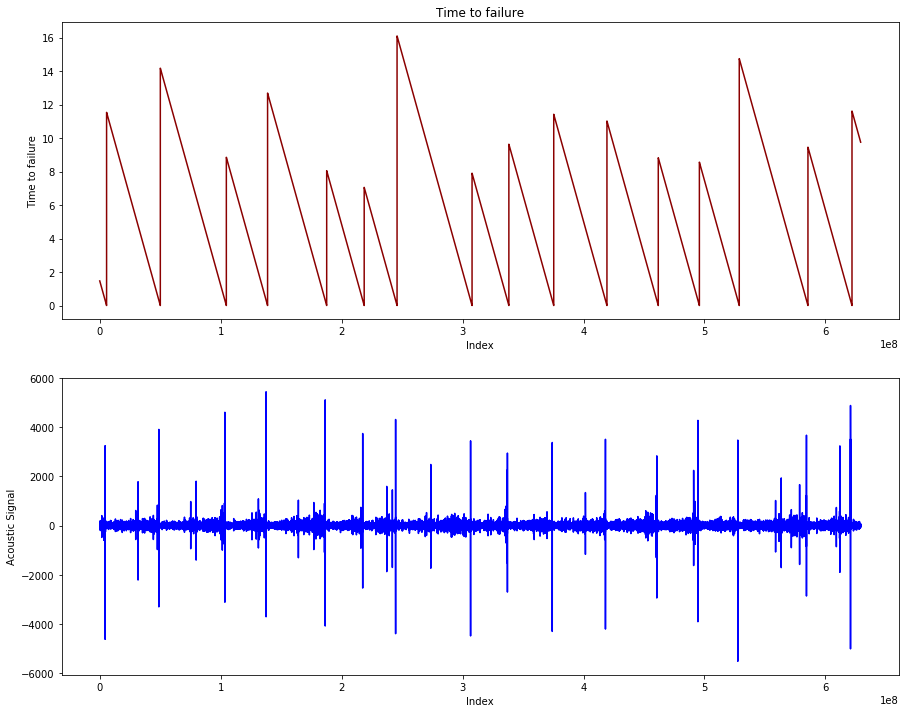

In [5]:
#plotting the train data
fig, ax = plt.subplots(2,1, figsize=(15,12))
ax[0].plot(train.index.values, train.time_to_failure.values, c="darkred")
ax[0].set_title("Time to failure")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Time to failure");
ax[1].plot(train.index.values, train.acoustic_data.values, c="blue")
#ax[1].set_title("Index")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Acoustic Signal")
plt.show()

It is given that the earthquake occurs when the time_to_failure hits 0, hence we can count that there are 16 occurences of earthquake in the whole training data

### Relationship between time to failure and acoustic data

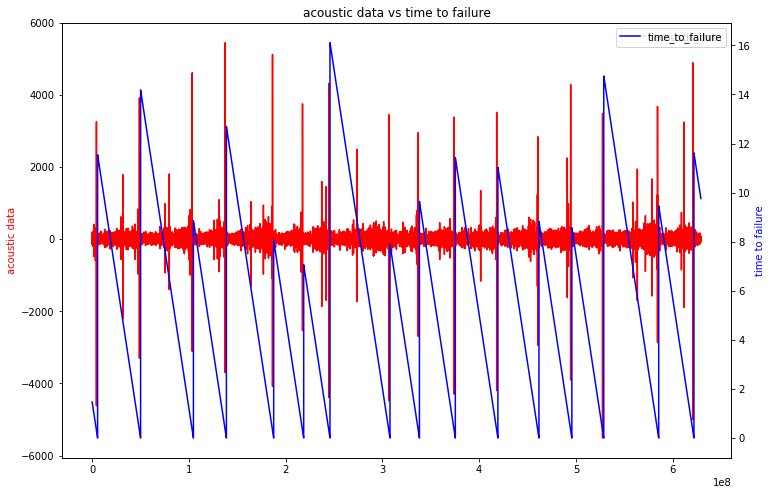

In [4]:
#plotting acoustic data vs time to failure
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.plot(train.acoustic_data,color='r')
plt.legend()
ax1.set_ylabel('acoustic data',color='r')
ax2=ax1.twinx()
ax2.set_ylabel('time to failure',color='b')
plt.plot(train.time_to_failure,color='b')
plt.title('acoustic data vs time to failure')
plt.legend()
plt.show()

The acoustic data has a peak just before time to failure hits zero. We can verify it by zooming into the plot.

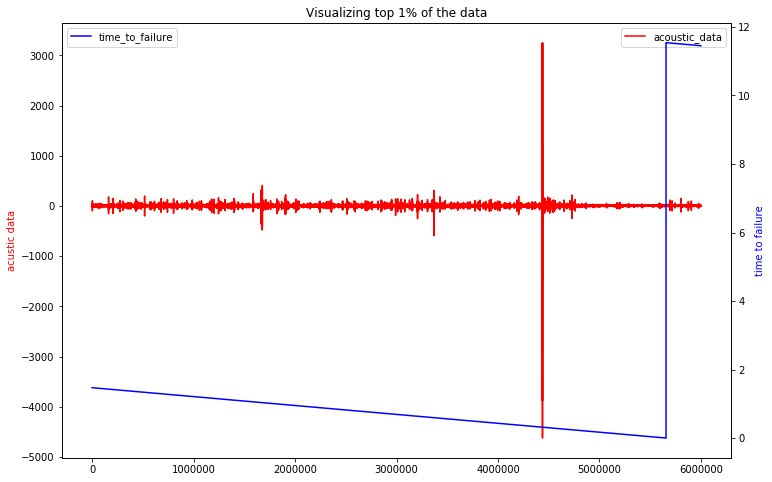

In [5]:
#plotting only top 1% of the value
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.plot(train.acoustic_data[0:6000000],color='r')
plt.legend()
ax1.set_ylabel('acustic data',color='r')
ax2=ax1.twinx()
ax2.set_ylabel('time to failure',color='b')
plt.plot(train.time_to_failure[0:6000000],color='b')
plt.title('Visualizing top 1% of the data')
plt.legend()
plt.show()

If we zoom into the data we can see that the acoustic data has a peak just before the earthquake occurs and the whole training data follows the same pattern

### Is time to failure continously Decreasing

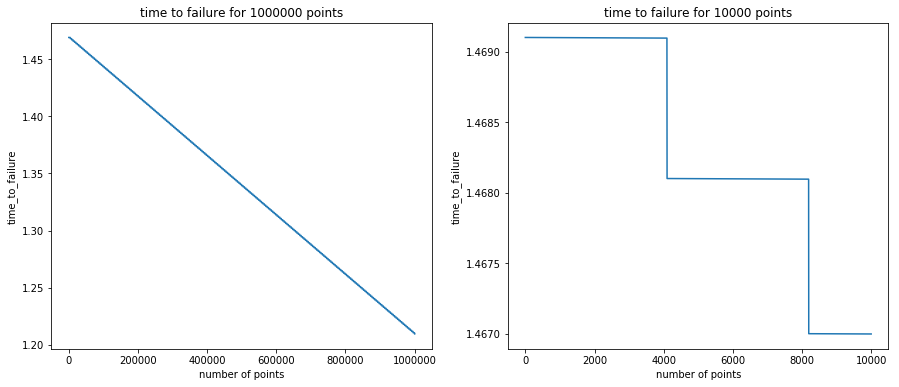

In [3]:
#plotting time to failure for fewer data
fig = plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)

plt.plot(train.time_to_failure[0:1000000])
plt.title('time to failure for 1000000 points')
plt.xlabel('number of points')
plt.ylabel('time_to_failure')
 
plt.subplot(1,2,2)
plt.plot(train.time_to_failure[0:10000])
plt.xlabel('number of points')
plt.ylabel('time_to_failure')
plt.title('time to failure for 10000 points')

plt.show()

If we plot the data for 1000000 points we can see that the graph is continously decreasing but if we zoom into it we can see that the time_to_failure stops decreasing for a while when it reaches ~4000 samples.
<br>
It is due to the fact that the data is recorded in bins of 4096 samples and the recording device stops for 12 microseconds after each bin.

### Visualizing Test Data

In [36]:
#Reading the test data
from tqdm.auto import tqdm
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
test = pd.DataFrame(dtype=np.float64, index=submission.index)
whole_test=[]
for seg_id in tqdm(test.index):
    seg = pd.read_csv('Untitled Folder/' + seg_id + '.csv')
    for i in seg['acoustic_data'].values:
        whole_test.append(i)

In [40]:
#total number of datapoints in test
len(whole_test)

393600000

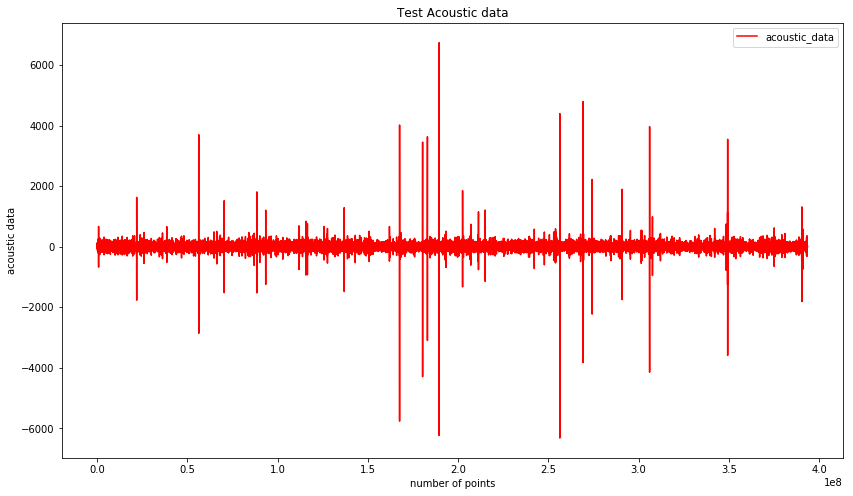

In [39]:
#plotting test data
fig = plt.figure(figsize=(14, 8))

plt.plot(whole_test,color='r',label='acoustic_data')
plt.title('Test Acoustic data')
plt.xlabel('number of points')
plt.ylabel('acoustic data')
plt.legend()
plt.show()
 

#### Checking for Null values

In [41]:
train.isnull().any().any()

False

There are no null values in the whole training data

In [46]:

#n = 100  # the larger n is, the smoother curve will be
#b = [1.0 / n] * n
#a = 1
#x = lfilter(b,a,train.acoustic_data)

In [8]:
#http://gilestrolab.github.io/pyrem/pyrem.univariate.html
#http://pyeeg.sourceforge.net/
#returns acivity, mobility and complexity of the signal
def hjorth(a):
    
    first_deriv = np.diff(a)
    second_deriv = np.diff(a,2)

    var_zero = np.mean(a ** 2)
    var_d1 = np.mean(first_deriv ** 2)
    var_d2 = np.mean(second_deriv ** 2)

    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility

    return activity, mobility, complexity

#returns the coefficient of linear regression
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]


### Featurizing the data

In [9]:
# Create a training file with simple features

rows = 150000
segments = int(np.floor(train.shape[0] / rows))
X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['peak_count','peak_std','peak_mean','trend','hjorth_0','hjorth_1','hjorth_2','ave', 
                                'std', 'max', 'min','skew','kurt','max/min','max-min','percentile_0.01',
                                'percentile_99.99','percentile_99.95','Rmean','Rstd','Rmax','Rmin','percentile_0.05',
                                'percentile_99.9' ,'Moving_avg_10_mean','Moving_avg_50_mean','exp_Moving_avg_50_mean',
                                'exp_Moving_avg_10_mean','Moving_avg_500_mean','Moving_avg_5000_mean',
                                'exp_Moving_avg_500_mean','exp_Moving_avg_5000_mean',
                                'percentile_99','consec_diff_mean','std_f_10000','std_f_50000',
                                'iqr','Moving_avg_500_std','Moving_avg_5000_std','Moving_avg_50000_std',
                                'exp_Moving_avg_50000_mean','Moving_avg_50000_mean','std_f_50000','std_l_50000',
                                'Hilbert_mean','Hann_window_mean','Moving_avg_50_std','Moving_avg_10_std'])
#
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])


In [101]:
X_train.shape

(4194, 48)

In [10]:
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    #fourier transform
    z = np.fft.fft(x)
    dfx=pd.DataFrame(x,columns=['acoustic_data'])
    y = seg['time_to_failure'].values[-1]
    y_train.loc[segment, 'time_to_failure'] = y
    imagFFT = np.imag(z)
    
    
    X_train.loc[segment, 'trend']=add_trend_feature(x, abs_values=False)
    #activity,mobility and complexity 
    X_train.loc[segment, 'hjorth_0'] =hjorth(x)[0]
    X_train.loc[segment, 'hjorth_1'] =hjorth(x)[1]
    X_train.loc[segment, 'hjorth_2'] =hjorth(x)[2]
    #X_train.loc[segment, 'dfa'] =dfa(x, Ave=None, L=None)
    
    #returns the peak of the signal
    peaks=scipy.signal.find_peaks(x,100)[1]['peak_heights']
    X_train.loc[segment, 'peak_count']=len(peaks)
    X_train.loc[segment, 'peak_std']=np.std(peaks)
    X_train.loc[segment, 'peak_mean']=np.mean(peaks)
    
    # considering the real part of fft
    realFFT = np.real(z)
    
    X_train.loc[segment, 'Rmean'] = realFFT.mean()
    X_train.loc[segment, 'Rstd'] = realFFT.std()
    X_train.loc[segment, 'Rmax'] = realFFT.max()
    X_train.loc[segment, 'Rmin'] = realFFT.min()
    
    #statistical features
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'skew'] =skew(x)
    X_train.loc[segment, 'kurt'] = kurtosis(x)
    X_train.loc[segment, 'median'] = np.median(x)
    X_train.loc[segment, 'percentile_0.01'] = np.percentile(x,0.01)
    X_train.loc[segment, 'percentile_99.99'] = np.percentile(x,99.99)
    X_train.loc[segment, 'percentile_99.95'] = np.percentile(x,99.95)
    X_train.loc[segment, 'percentile_0.05'] = np.percentile(x,0.05)
    X_train.loc[segment, 'percentile_99.9'] = np.percentile(x,99.9)
    X_train.loc[segment, 'percentile_99'] = np.percentile(x,99)
    X_train.loc[segment, 'std_f_10000'] = x[0:10000].std()
    X_train.loc[segment, 'std_l_10000'] = x[40000:50000].std()
    X_train.loc[segment, 'std_f_50000'] = x[0:50000].std()
    X_train.loc[segment, 'std_l_50000'] = x[100000:150000].std()
    X_train.loc[segment, 'max/min'] = x.max()/x.min()
    X_train.loc[segment, 'max-min'] = x.max()-x.min()
    X_train.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    
    #moving and exponential moving averages
    X_train.loc[segment, 'Moving_avg_50_std'] = dfx['acoustic_data'].rolling(window=50).std().mean(skipna=True)
    X_train.loc[segment, 'Moving_avg_10_std'] = dfx['acoustic_data'].rolling(window=10).std().mean(skipna=True)
    X_train.loc[segment, 'Moving_avg_500_std'] = dfx['acoustic_data'].rolling(window=500).std().mean(skipna=True)
    X_train.loc[segment, 'Moving_avg_5000_std'] = dfx['acoustic_data'].rolling(window=5000).std().mean(skipna=True)
    X_train.loc[segment, 'Moving_avg_50000_std'] = dfx['acoustic_data'].rolling(window=50000).std().mean(skipna=True)
    X_train.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_train.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_train.loc[segment, 'Moving_avg_50_mean'] = dfx['acoustic_data'].rolling(window=50).mean().mean(skipna=True)
    X_train.loc[segment, 'Moving_avg_10_mean'] = dfx['acoustic_data'].rolling(window=10).mean().mean(skipna=True)
    X_train.loc[segment, 'Moving_avg_500_mean'] = dfx['acoustic_data'].rolling(window=500).mean().mean(skipna=True)
    X_train.loc[segment, 'Moving_avg_5000_mean'] = dfx['acoustic_data'].rolling(window=5000).mean().mean(skipna=True)
    X_train.loc[segment, 'Moving_avg_50000_mean'] = dfx['acoustic_data'].rolling(window=50000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_train.loc[segment, 'exp_Moving_avg_50_mean'] = (ewma(dfx['acoustic_data'], span=50).mean()).mean(skipna=True)
    X_train.loc[segment, 'exp_Moving_avg_10_mean'] = (ewma(dfx['acoustic_data'], span=10).mean()).mean(skipna=True)
    X_train.loc[segment, 'exp_Moving_avg_500_mean'] = (ewma(dfx['acoustic_data'], span=500).mean()).mean(skipna=True)
    X_train.loc[segment, 'exp_Moving_avg_5000_mean'] = (ewma(dfx['acoustic_data'], span=5000).mean()).mean(skipna=True)
    X_train.loc[segment, 'exp_Moving_avg_50000_mean'] = (ewma(dfx['acoustic_data'], span=50000).mean()).mean(skipna=True)
    
    #taking the difference between consecutive samples and mean.
    cc=dfx['acoustic_data']- dfx['acoustic_data'].shift(-1)
    cv=cc.fillna(dfx['acoustic_data'].tail(1))
    X_train.loc[segment, 'consec_diff_mean'] = cv.mean()

In [11]:
X_train.head()

,peak_count,peak_std,peak_mean,trend,hjorth_0,hjorth_1,hjorth_2,ave,std,max,...,exp_Moving_avg_50000_mean,Moving_avg_50000_mean,std_f_50000,std_l_50000,Hilbert_mean,Hann_window_mean,Moving_avg_50_std,Moving_avg_10_std,median,std_l_10000
0,1.0,0.000000,104.000000,-3.268300e-06,49.875673,0.480837,2.949767,4.884113,5.101089,104.0,...,4.953219,4.930208,6.488487,3.664627,7.027028,4.883327,4.011743,3.507118,5.0,4.653028
1,13.0,23.206049,127.307692,9.090424e-07,65.745180,0.453286,2.918704,4.725767,6.588802,181.0,...,4.720102,4.719066,7.305160,5.493016,7.380383,4.725049,4.379248,3.761435,5.0,5.287957
2,6.0,13.148722,110.666667,3.962182e-06,72.616993,0.440686,2.950026,4.906393,6.967374,140.0,...,4.842499,4.907583,6.104775,8.603610,8.016930,4.905511,4.849219,4.080841,5.0,5.318101
3,11.0,37.245666,144.181818,1.637207e-06,68.454693,0.448160,2.924000,4.902240,6.922282,197.0,...,4.887399,4.876404,6.238047,5.652385,7.606850,4.901428,4.475839,3.788192,5.0,5.079281
4,7.0,10.669430,127.857143,-6.668392e-07,77.401387,0.416186,3.172026,4.908720,7.301086,145.0,...,4.923698,4.940916,5.323776,7.694429,7.895403,4.908115,4.700727,3.835604,5.0,4.607163


In [12]:
#since peak_std and peak_mean will be null if there are no peaks in the signal
print(X_train.isnull().any().any())
#filling null values with zero
X_train2=X_train.fillna(0)

True


In [13]:
X_train2.head()

,peak_count,peak_std,peak_mean,trend,hjorth_0,hjorth_1,hjorth_2,ave,std,max,...,exp_Moving_avg_50000_mean,Moving_avg_50000_mean,std_f_50000,std_l_50000,Hilbert_mean,Hann_window_mean,Moving_avg_50_std,Moving_avg_10_std,median,std_l_10000
0,1.0,0.000000,104.000000,-3.268300e-06,49.875673,0.480837,2.949767,4.884113,5.101089,104.0,...,4.953219,4.930208,6.488487,3.664627,7.027028,4.883327,4.011743,3.507118,5.0,4.653028
1,13.0,23.206049,127.307692,9.090424e-07,65.745180,0.453286,2.918704,4.725767,6.588802,181.0,...,4.720102,4.719066,7.305160,5.493016,7.380383,4.725049,4.379248,3.761435,5.0,5.287957
2,6.0,13.148722,110.666667,3.962182e-06,72.616993,0.440686,2.950026,4.906393,6.967374,140.0,...,4.842499,4.907583,6.104775,8.603610,8.016930,4.905511,4.849219,4.080841,5.0,5.318101
3,11.0,37.245666,144.181818,1.637207e-06,68.454693,0.448160,2.924000,4.902240,6.922282,197.0,...,4.887399,4.876404,6.238047,5.652385,7.606850,4.901428,4.475839,3.788192,5.0,5.079281
4,7.0,10.669430,127.857143,-6.668392e-07,77.401387,0.416186,3.172026,4.908720,7.301086,145.0,...,4.923698,4.940916,5.323776,7.694429,7.895403,4.908115,4.700727,3.835604,5.0,4.607163


In [90]:
#standardizing the data
scaler = StandardScaler()
scaler.fit(X_train2)
X_train_scaled = scaler.transform(X_train2)
#X_test_scaled = scaler.transform(X_train2[3701:])

Tried denoising the data using a filter but the results were same.

## Machine Learning Models 

In [192]:
# utility function to plot the output
def plot_op(y_predicted):
    plt.figure(figsize=(12,6))
    plt.plot(y_train,label='Time to Failure')
    plt.plot(y_predicted,label='Predicted Time to Failure')
    plt.xlabel('index')
    plt.ylabel('Time to failure')
    plt.legend()
    plt.title('Predictions')
    plt.show()

#to plot feature importances of respective models
def plot_importance(clf):
    fig, ax = plt.subplots(figsize=(15, 10))

    my_dict={}
    #getting feature names and score
    for a,b in zip(X_train.columns,clf.feature_importances_):
        my_dict[a]=b 
    import collections
    #to get top 10 features
    c = collections.Counter(my_dict)
    g=c.most_common(10)
    keys=[]
    values=[]
    for i in range(len(g)):
        keys.append(g[i][0])
        values.append(g[i][1])
    plt.bar(keys,values)
    plt.title('feature importances')
    plt.xlabel('features')
    plt.show()

### SVM 

In [86]:
#finding the hyperparameters using gridsearchcv
alphalist=np.concatenate([np.linspace(0.001, 1, 50), np.linspace(1, 100, 10)]).tolist()
grid={"C":alphalist}
svm=SVR(degree=3, tol=0.001, shrinking=True, verbose=False, max_iter=-1)
clf1=GridSearchCV(svm,grid,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error',verbose=1)
clf1.fit(X_train_scaled,y_train.values.flatten())
print('The best parameters are :',clf1.best_params_)
print('The best score is:',clf1.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   48.9s finished


The best parameters are : {'C': 0.775734693877551}
The best score is: -2.2334527116874776


Mean Absolute Error on test data is: 2.084


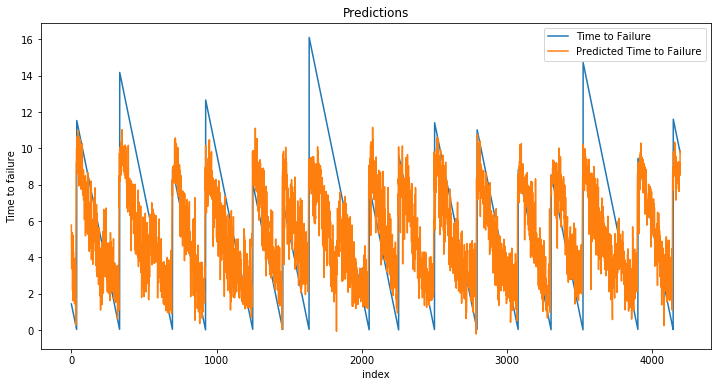

In [235]:
#predicting and plotting on train data
svm=SVR(kernel='rbf', degree=3, tol=0.001,C=0.776,  shrinking=True, cache_size=200, verbose=False, max_iter=-1)
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred_svm=svm.predict(X_train_scaled)
score_svm = mean_absolute_error(y_train.values.flatten(), y_pred_svm)
print('Mean Absolute Error on test data is: {0:.3f}'.format(score_svm))
plot_op(y_pred_svm)

The model predicts well but does not fit to the peak points

### XGBOOST

In [199]:
#finding the hyperparameters using gridsearchcv
grid={'n_estimators':[int(i) for i in np.linspace(1, 100, 50).tolist()], 'max_depth':[int(i) for i in np.linspace(1, 10, 10).tolist()]}
#train_pool = Pool(X_train_scaled,train_y)
xg = xgb.XGBRegressor(verbose=10,n_jobs=-1)
clf5=GridSearchCV(xg,grid,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error',verbose=1)
clf5.fit(X_train_scaled,y_train.values.flatten())
print('The best parameters are :',clf5.best_params_)
print('The best score is:',clf5.best_score_)


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 547 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1175 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 1625 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2175 tasks      | elapsed:  2.0min


The best parameters are : {'n_estimators': 25, 'max_depth': 2}
The best score is: -2.2120059371338825


[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  2.8min finished


Mean Absolute Error is: 2.118


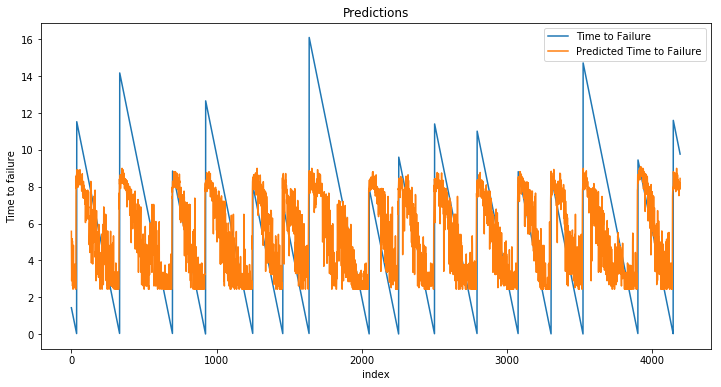

In [236]:
#predicting on training data to visualize the output
import xgboost as xgb
xg = xgb.XGBRegressor(verbose=10,n_jobs=-1,n_estimators=25, max_depth=2)

xg.fit(X_train_scaled,y_train.values.flatten())
y_pred_xgb=xg.predict(X_train_scaled)
score_xgb = mean_absolute_error(y_train.values.flatten(), y_pred_xgb)
print('Mean Absolute Error is: {0:.3f}'.format(score_xgb))
plot_op(y_pred_xgb)

We can see that the model is not able to find the peak points

#### Feature Importances

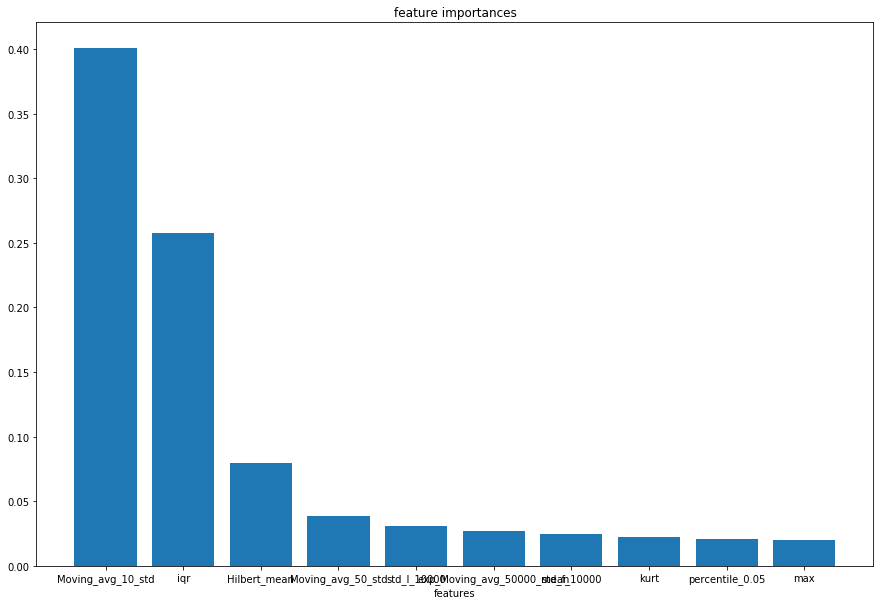

In [202]:
plot_importance(xg)

Moving_avg_std_10 is the most important feature followed by iqr

### CatBoost Model

Mean Absolute Error is: 1.824


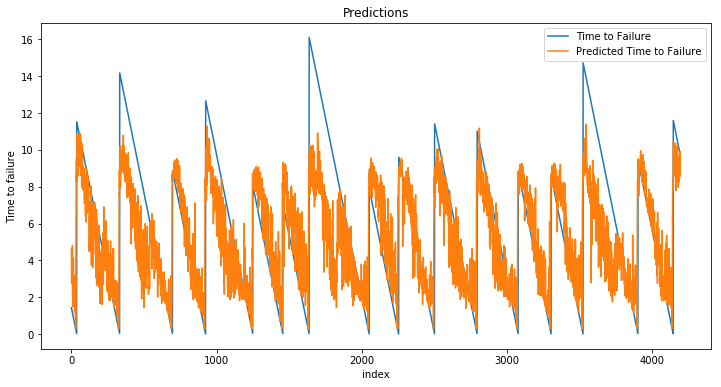

In [238]:

train_pool = Pool(X_train_scaled,y_train)
cat_model = CatBoostRegressor(
                               boosting_type='Ordered',
                               loss_function='MAE',    
                                iterations= 4000
                              )

cat_model.fit(X_train_scaled,y_train,silent=True)
y_pred_cat=cat_model.predict(X_train_scaled)
score_cat = mean_absolute_error(y_train.values.flatten(), y_pred_cat)
#print(f'Score: {score:0.3f}')
print('Mean Absolute Error is: {0:.3f}'.format(score_cat))
plot_op(y_pred_cat)

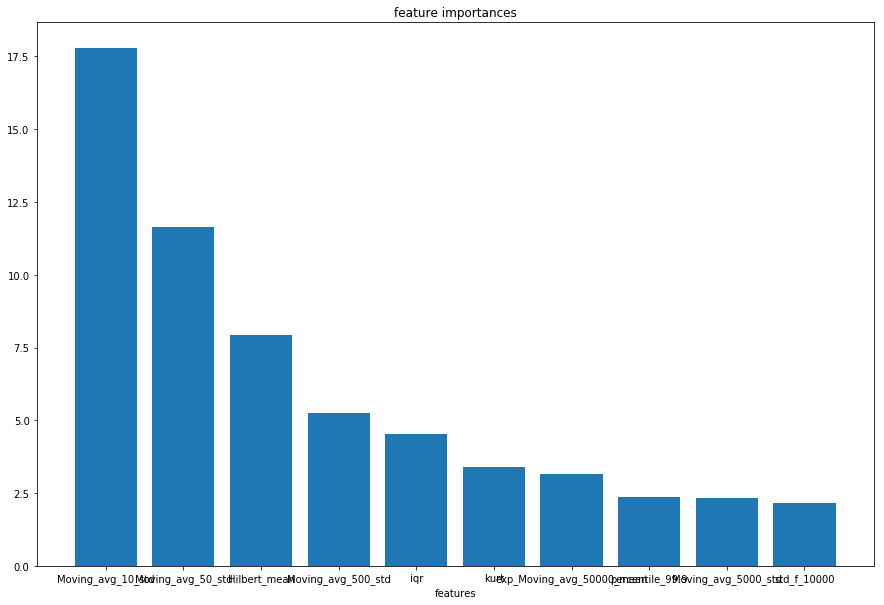

In [194]:
plot_importance(cat_model)

### Random Forest

In [158]:
from sklearn.ensemble import RandomForestRegressor
#finding the hyperparameters using gridsearchcv
grid={'n_estimators':[int(i) for i in np.linspace(1, 100, 30).tolist()], 'max_depth':[int(i) for i in np.linspace(1, 15, 6).tolist()]}

rf = RandomForestRegressor(n_jobs=-1, verbose=10)
clf6=GridSearchCV(rf,grid,cv=10,n_jobs=-1,scoring='neg_mean_absolute_error',verbose=1)
clf6.fit(X_train_scaled,y_train.values.flatten())
print('The best parameters are :',clf6.best_params_)
print('The best score is:',clf6.best_score_)


Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  6.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  38 | elapsed:    0.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   7 out of  38 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  11 out of  38 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  38 | elapsed:    0.2s remaining:    0.3s


building tree 1 of 38
building tree 2 of 38
building tree 3 of 38
building tree 4 of 38
building tree 5 of 38
building tree 6 of 38
building tree 7 of 38
building tree 8 of 38
building tree 9 of 38
building tree 10 of 38
building tree 11 of 38
building tree 12 of 38building tree 13 of 38
building tree 14 of 38
building tree 15 of 38
building tree 16 of 38
building tree 17 of 38
building tree 18 of 38
building tree 19 of 38
building tree 20 of 38
building tree 21 of 38
building tree 22 of 38

building tree 23 of 38
building tree 24 of 38
building tree 25 of 38
building tree 26 of 38
building tree 27 of 38
building tree 28 of 38
building tree 29 of 38building tree 30 of 38building tree 31 of 38
building tree 32 of 38


building tree 33 of 38building tree 34 of 38

building tree 35 of 38building tree 36 of 38
building tree 37 of 38

building tree 38 of 38
The best parameters are : {'n_estimators': 38, 'max_depth': 9}
The best score is: -2.3093861535788998


[Parallel(n_jobs=-1)]: Done  19 out of  38 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  23 out of  38 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  27 out of  38 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  31 out of  38 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  38 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    0.3s finished


Mean Absolute Error is: 2.061


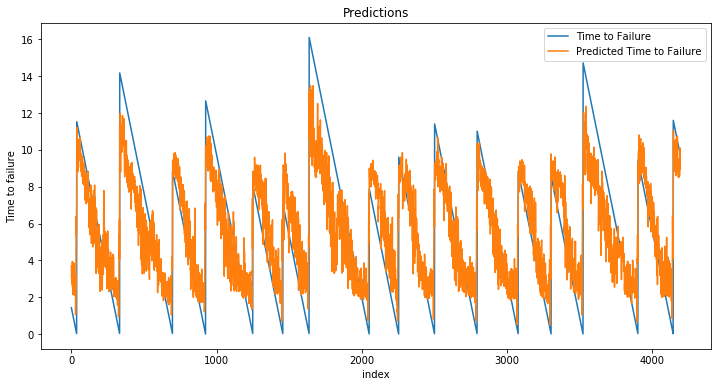

In [159]:
rf = RandomForestRegressor(n_jobs=-1,n_estimators=38, max_depth=9)
rf.fit(X_train_scaled,y_train.values.flatten())
y_pred_rf=rf.predict(X_train_scaled)
score_rf = mean_absolute_error(y_train.values.flatten(), y_pred_rf)
#print(f'Score: {score:0.3f}')
print('Mean Absolute Error is: {0:.3f}'.format(score_xgb))
plot_op(y_pred_rf)

#### Feature Importance

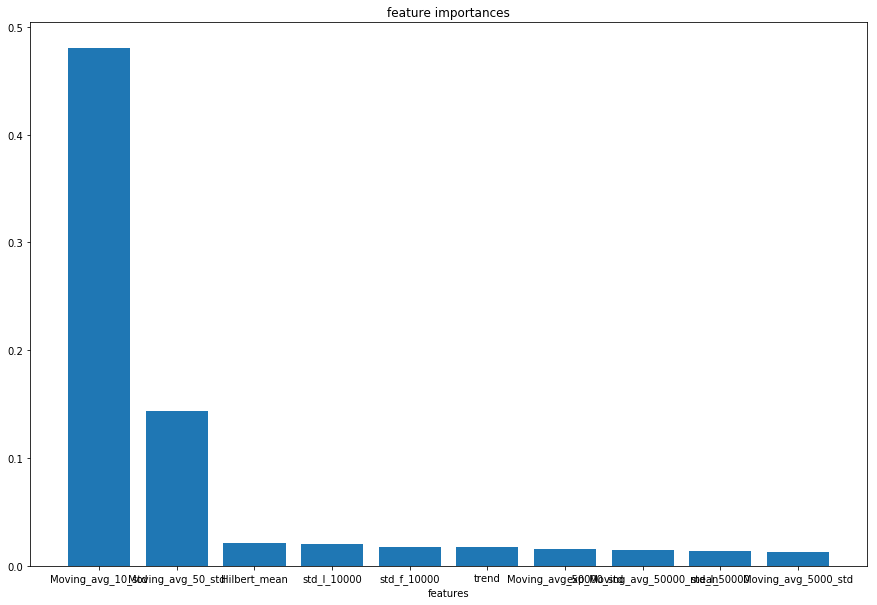

In [195]:
plot_importance(rf)

## Feature Selection

In [162]:
import sklearn
#normalising, since sklearns selectkbest does not work with negative features
scaler = sklearn.preprocessing.MinMaxScaler()
X_train_norm=scaler.fit_transform(X_train2)
#converting to dataframe
X_train_norm=pd.DataFrame(X_train_norm,columns=X_train.columns)

               features        Score
36                  iqr  1450.318911
5              hjorth_1  1402.870727
4              hjorth_0   695.818758
47    Moving_avg_10_std   616.268155
37   Moving_avg_500_std   590.588305
38  Moving_avg_5000_std   590.221087
46    Moving_avg_50_std   559.393004
2             peak_mean   558.887042
44         Hilbert_mean   456.747846
32        percentile_99   423.174034
----------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------


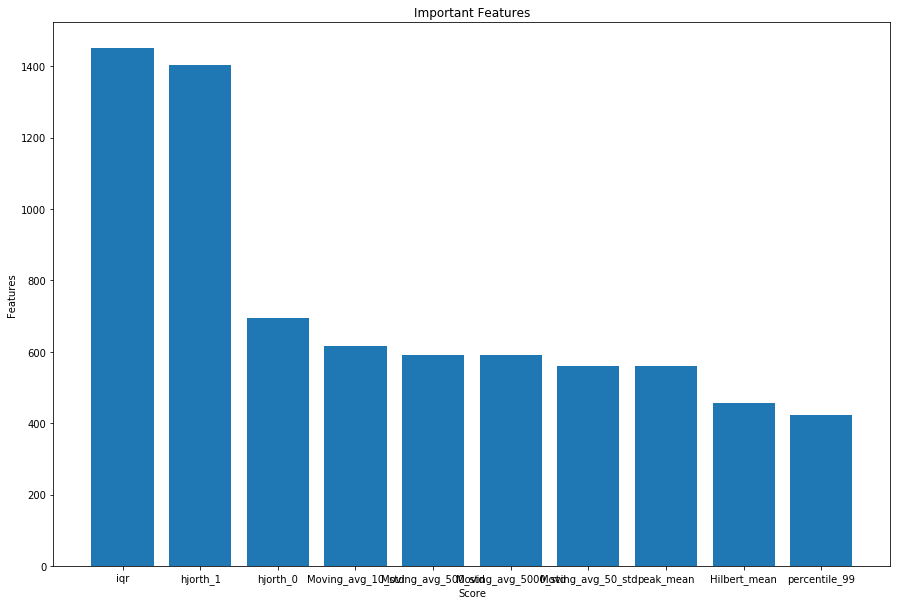

In [184]:
#using sklearns selectkbest
fig, ax = plt.subplots(figsize=(15, 10))
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = X_train_norm 
y = y_train.values.flatten().tolist()
#  extracting top 10 features
bestfeatures = SelectKBest(score_func=sklearn.feature_selection.f_regression, k=10)
fit = bestfeatures.fit(X,y)
scores_df = pd.DataFrame(fit.scores_)
columns_df = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
topfeatures = pd.concat([columns_df,scores_df],axis=1)
topfeatures.columns = ['features','Score']  

topfeatures=topfeatures.sort_values(by='Score',ascending=False)
print(topfeatures[0:10])
print('----------------------------------------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------------------------------------')
plt.bar(topfeatures.features[0:10],topfeatures.Score[0:10])
plt.ylabel('Features')
plt.title('Important Features')
plt.xlabel('Score')
plt.show()

####  using only top features

In [186]:
X_train2.columns[[36,5,4,47,37,38,46,2,44,32]]

Index(['iqr', 'hjorth_1', 'hjorth_0', 'Moving_avg_10_std',
       'Moving_avg_500_std', 'Moving_avg_5000_std', 'Moving_avg_50_std',
       'peak_mean', 'Hilbert_mean', 'percentile_99'],
      dtype='object')

In [187]:
#considering top features
X_train4=X_train2[['iqr', 'hjorth_1', 'hjorth_0', 'Moving_avg_10_std',
       'Moving_avg_500_std', 'Moving_avg_5000_std', 'Moving_avg_50_std',
       'peak_mean', 'Hilbert_mean', 'percentile_99']]

In [188]:
#since peak_std and peak_mean will be null if there are no peaks in the signal
print(X_train4.isnull().any().any())
#filling null values with zero
X_train_top=X_train4.fillna(0)

#standardizing the data
scaler = StandardScaler()
scaler.fit(X_train_top)
X_train_scaled_top = scaler.transform(X_train_top)

False


### SVM

In [190]:
#finding the hyperparameters using gridsearchcv
alphalist=np.concatenate([np.linspace(0.001, 1, 50), np.linspace(1, 100, 10)]).tolist()
grid={"C":alphalist}
svm=SVR(degree=3, tol=0.001, shrinking=True, verbose=False, max_iter=-1)
clf1=GridSearchCV(svm,grid,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error',verbose=1)
clf1.fit(X_train_scaled_top,y_train.values.flatten())
print('The best parameters are :',clf1.best_params_)
print('The best score is:',clf1.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.7s finished


The best parameters are : {'C': 1.0}
The best score is: -2.168056875251725


Mean Absolute Error on test data is: 2.084


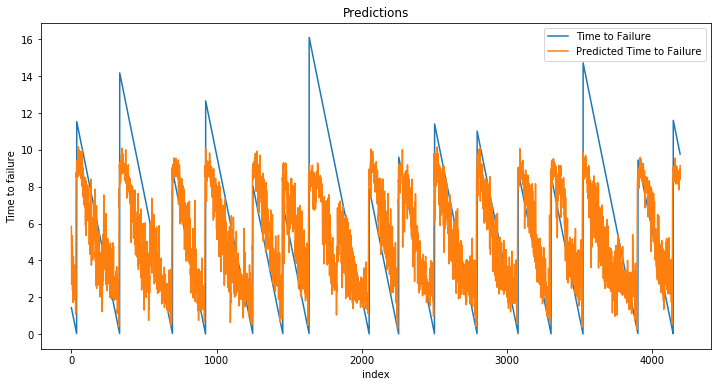

In [240]:
#predicting and plotting on train data
svm=SVR(kernel='rbf', degree=3, tol=0.001,C=1,  shrinking=True, cache_size=200, verbose=False, max_iter=-1)
svm.fit(X_train_scaled_top, y_train.values.flatten())
y_pred_svm=svm.predict(X_train_scaled_top)
score_svm = mean_absolute_error(y_train.values.flatten(), y_pred_svm)
print('Mean Absolute Error on test data is: {0:.3f}'.format(score_svm))
plot_op(y_pred_svm)

### XGBoost

In [204]:
#finding the hyperparameters using gridsearchcv
grid={'n_estimators':[int(i) for i in np.linspace(1, 100, 50).tolist()], 'max_depth':[int(i) for i in np.linspace(1, 10, 10).tolist()]}
xg = xgb.XGBRegressor(verbose=10,n_jobs=-1)
clf7=GridSearchCV(xg,grid,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error',verbose=1)
clf7.fit(X_train_scaled_top,y_train.values.flatten())
print('The best parameters are :',clf7.best_params_)
print('The best score is:',clf7.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 183 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 683 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1383 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 1904 tasks      | elapsed:   27.8s


The best parameters are : {'n_estimators': 25, 'max_depth': 3}
The best score is: -2.1865879084428785


[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   46.1s finished


Mean Absolute Error is: 2.086


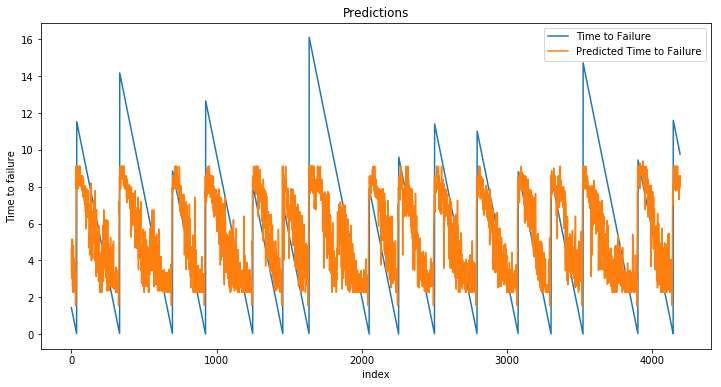

In [241]:
#predicting on training data to visualize the output
import xgboost as xgb
xg = xgb.XGBRegressor(verbose=10,n_jobs=-1,n_estimators=25, max_depth=3)

xg.fit(X_train_scaled_top,y_train.values.flatten())
y_pred_xgb=xg.predict(X_train_scaled_top)
score_xgb = mean_absolute_error(y_train.values.flatten(), y_pred_xgb)
#print(f'Score: {score:0.3f}')
print('Mean Absolute Error is: {0:.3f}'.format(score_xgb))
plot_op(y_pred_xgb)

#### CatBoost Model

Mean Absolute Error is: 1.960


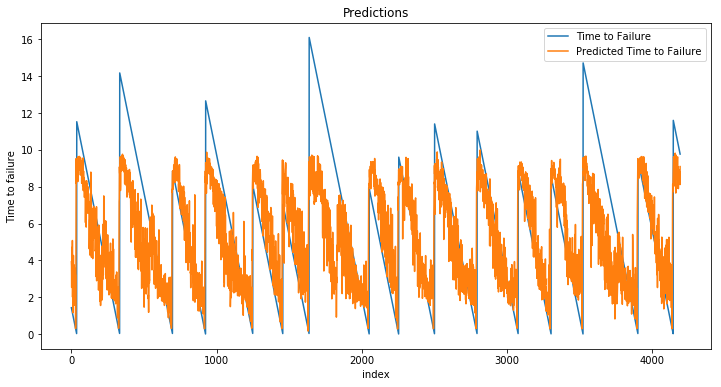

In [210]:

train_pool = Pool(X_train_scaled,y_train)
cat_model = CatBoostRegressor(
                               boosting_type='Ordered',
                               loss_function='MAE',
                               
                                iterations= 3000
                              )

cat_model.fit(X_train_scaled_top,y_train,silent=True)
y_pred_cat=cat_model.predict(X_train_scaled_top)
score_cat = mean_absolute_error(y_train.values.flatten(), y_pred_cat)
#print(f'Score: {score:0.3f}')
print('Mean Absolute Error is: {0:.3f}'.format(score_cat))
#CatBoostRegressor.plot_importance(cat_model)
#1.765
plot_op(y_pred_cat)

## Truncated SVD

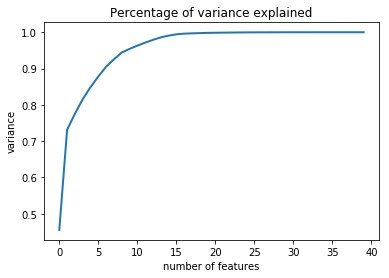

In [211]:

#applying truncated svd with n_components =40
tsvd =TruncatedSVD(algorithm="randomized",n_components=40, n_iter=7,\
                   random_state=42,tol=0.0)
X_reduced = tsvd.fit_transform(X_train_scaled)

#plotting the percentage of the variance explained by the features
percentage_variance_explained=tsvd.explained_variance_/sum(tsvd.explained_variance_)
cum_variance_explained=np.cumsum(percentage_variance_explained)
plt.plot(cum_variance_explained,linewidth='2')
plt.xlabel("number of features")
plt.ylabel("variance")
plt.title("Percentage of variance explained")
plt.show()

In [212]:
tsvd =TruncatedSVD(algorithm="randomized",n_components=15, n_iter=7,\
                   random_state=42,tol=0.0)
tsvd_reduced = tsvd.fit_transform(X_train_scaled)

#### SVM

In [213]:
#finding the hyperparameters using gridsearchcv
alphalist=np.concatenate([np.linspace(0.001, 1, 50), np.linspace(1, 100, 10)]).tolist()
grid={"C":alphalist}
svm=SVR(degree=3, tol=0.001, shrinking=True, verbose=False, max_iter=-1)
clf8=GridSearchCV(svm,grid,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error',verbose=1)
clf8.fit(tsvd_reduced,y_train.values.flatten())
print('The best parameters are :',clf8.best_params_)
print('The best score is:',clf8.best_score_)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   36.1s finished


The best parameters are : {'C': 0.7349591836734695}
The best score is: -2.2871278122619496


Mean Absolute Error on test data is: 2.051


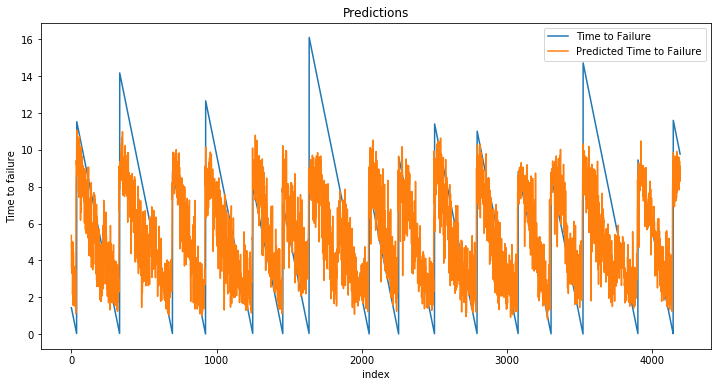

In [214]:
#predicting and plotting on train data
svm=SVR(kernel='rbf', degree=3, tol=0.001,C=0.735,  shrinking=True, cache_size=200, verbose=False, max_iter=-1)
svm.fit(tsvd_reduced, y_train.values.flatten())
y_pred_svm=svm.predict(tsvd_reduced)
score_svm = mean_absolute_error(y_train.values.flatten(), y_pred_svm)
print('Mean Absolute Error on test data is: {0:.3f}'.format(score_svm))
plot_op(y_pred_svm)

#### XGBoost

In [215]:
#finding the hyperparameters using gridsearchcv
grid={'n_estimators':[int(i) for i in np.linspace(1, 100, 50).tolist()], 'max_depth':[int(i) for i in np.linspace(1, 10, 10).tolist()]}

xg = xgb.XGBRegressor(verbose=10,n_jobs=-1)
clf9=GridSearchCV(xg,grid,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error',verbose=1)
clf9.fit(tsvd_reduced,y_train.values.flatten())
print('The best parameters are :',clf9.best_params_)
print('The best score is:',clf9.best_score_)



Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 931 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 1251 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 1601 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 2051 tasks      | elapsed:   45.6s


The best parameters are : {'n_estimators': 27, 'max_depth': 3}
The best score is: -2.2477934711856675


[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.2min finished


Mean Absolute Error is: 2.121


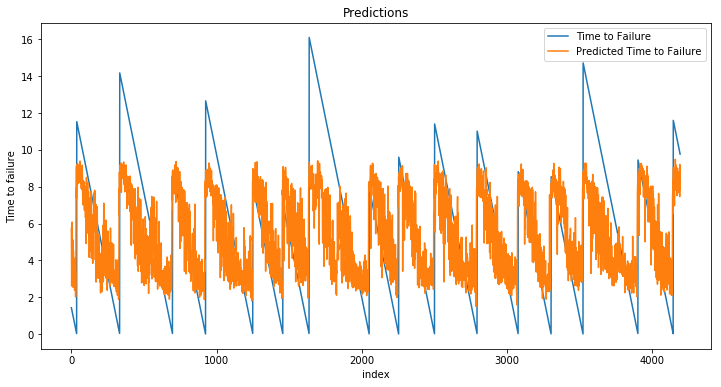

In [216]:
#predicting on training data to visualize the output
import xgboost as xgb
xg = xgb.XGBRegressor(verbose=10,n_jobs=-1,n_estimators=27, max_depth=3)

xg.fit(tsvd_reduced,y_train.values.flatten())
y_pred_xgb=xg.predict(tsvd_reduced)
score_xgb = mean_absolute_error(y_train.values.flatten(), y_pred_xgb)

print('Mean Absolute Error is: {0:.3f}'.format(score_xgb))
plot_op(y_pred_xgb)

#### Submitting results

In [55]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)


In [228]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [229]:
for seg_id in tqdm(X_test.index):
    
    seg = pd.read_csv('Untitled Folder/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    z = np.fft.fft(x)
    dfx=pd.DataFrame(x,columns=['acoustic_data'])

        
    #returns the peak of the signal
    peaks=scipy.signal.find_peaks(x,100)[1]['peak_heights']
    X_test.loc[seg_id, 'peak_count']=len(peaks)
    X_test.loc[seg_id, 'peak_std']=np.std(peaks)
    X_test.loc[seg_id, 'peak_mean']=np.mean(peaks)
    
    
    X_test.loc[seg_id, 'trend']=add_trend_feature(x, abs_values=False)
    #X_train.loc[segment, 'dfa'] = dfa(x, Ave=None, L=None)
    X_test.loc[seg_id, 'hjorth_0'] =hjorth(x)[0]
    X_test.loc[seg_id, 'hjorth_1'] =hjorth(x)[1]
    X_test.loc[seg_id, 'hjorth_2'] =hjorth(x)[2]
    #X_train.loc[segment, 'dfa'] =dfa(x, Ave=None, L=None)

    realFFT = np.real(z)
    imagFFT = np.imag(z)
    X_test.loc[seg_id, 'Rmean'] = realFFT.mean()
    X_test.loc[seg_id, 'Rstd'] = realFFT.std()
    X_test.loc[seg_id, 'Rmax'] = realFFT.max()
    X_test.loc[seg_id, 'Rmin'] = realFFT.min()
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
    X_test.loc[seg_id, 'skew'] =skew(x)
    X_test.loc[seg_id, 'kurt'] = kurtosis(x)

    X_train.loc[segment, 'median'] = np.median(x)#not useful
    X_test.loc[seg_id, 'percentile_0.01'] = np.percentile(x,0.01)
    X_test.loc[seg_id, 'percentile_99.99'] = np.percentile(x,99.99)
    X_test.loc[seg_id, 'percentile_99.95'] = np.percentile(x,99.95)
    X_test.loc[seg_id, 'percentile_0.05'] = np.percentile(x,0.05)
    X_test.loc[seg_id, 'percentile_99.9'] = np.percentile(x,99.9)
    X_test.loc[seg_id, 'percentile_99'] = np.percentile(x,99)
    X_test.loc[seg_id, 'std'] = x.std()
    
    X_test.loc[seg_id, 'std_f_10000'] = x[0:10000].std()
    
    X_test.loc[seg_id, 'std_l_10000'] = x[140000:150000].std()
    X_test.loc[seg_id, 'std_f_50000'] = x[0:50000].std()
    X_test.loc[seg_id, 'std_l_50000'] = x[100000:150000].std()
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[seg_id, 'Moving_avg_50_std'] = dfx['acoustic_data'].rolling(window=50).std().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_avg_10_std'] = dfx['acoustic_data'].rolling(window=10).std().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_avg_500_std'] = dfx['acoustic_data'].rolling(window=500).std().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_avg_5000_std'] = dfx['acoustic_data'].rolling(window=5000).std().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_avg_50000_std'] = dfx['acoustic_data'].rolling(window=50000).std().mean(skipna=True)
    X_test.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_test.loc[seg_id, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()


    X_test.loc[seg_id, 'max/min'] = x.max()/x.min()
    X_test.loc[seg_id, 'max-min'] = x.max()-x.min()
    X_test.loc[seg_id, 'Moving_avg_10_mean'] = dfx['acoustic_data'].rolling(window=10).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_avg_50_mean'] = dfx['acoustic_data'].rolling(window=50).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_avg_500_mean'] = dfx['acoustic_data'].rolling(window=500).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_avg_5000_mean'] = dfx['acoustic_data'].rolling(window=5000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_avg_50000_mean'] = dfx['acoustic_data'].rolling(window=50000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    
    X_test.loc[seg_id, 'exp_Moving_avg_50_mean'] = (ewma(dfx['acoustic_data'], span=50).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_avg_10_mean'] = (ewma(dfx['acoustic_data'], span=10).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_avg_500_mean'] = (ewma(dfx['acoustic_data'], span=500).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_avg_5000_mean'] = (ewma(dfx['acoustic_data'], span=5000).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_avg_50000_mean'] = (ewma(dfx['acoustic_data'], span=50000).mean()).mean(skipna=True)
    
    cc=dfx['acoustic_data']- dfx['acoustic_data'].shift(-1)
    cv=cc.fillna(dfx['acoustic_data'].tail(1))
    X_test.loc[seg_id, 'consec_diff_mean'] = cv.mean()
    

In [244]:
X_test1=X_test[['iqr', 'hjorth_1', 'hjorth_0', 'Moving_avg_10_std',
       'Moving_avg_500_std', 'Moving_avg_5000_std', 'Moving_avg_50_std',
       'peak_mean', 'Hilbert_mean', 'percentile_99']]

In [230]:
#since peak_std and peak_mean will be null if there are no peaks in the signal
print(X_test.isnull().any().any())
#filling null values with zero
X_test=X_test.fillna(0)

True


In [245]:
#standardizing the data
scaler = StandardScaler()
scaler.fit(X_test1)
X_test_scaled = scaler.transform(X_test1)

In [246]:
#pred_stack=(xg.predict(X_test_scaled)+svm.predict(X_test_scaled)+cat_model.predict(X_test_scaled))/3
pred_stack=(xg.predict(X_test_scaled)+svm.predict(X_test_scaled))/2

In [247]:
submission['time_to_failure'] = pred_stack
submission.to_csv('stacked2modelsubmissionon4.csv')

In [60]:
#score=1.474
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = cat_model.predict(X_test_scaled)
submission.to_csv('catmodel_10000_denoised_submission3.csv')

In [31]:
#score=1.53
#overfit
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = xgb.predict(X_test_scaled)
submission.to_csv('xgb_submission.csv')

## Conclusion

Objective:To predict the time remaining before laboratory earthquakes occur from real-time seismic data.

1. We are given a dataset with  629145480 rows and 2 columns: acoustic_data, time_to_failure, where time_to_failure is the time remaining for next earthquake.
<br>
2. We visualize the train and test data to get the pattern and observer that the there is a spike in siesmic data before earthquake occurs and there are a total of 16 earthquakes in train data.
<br>
3. We tried to denoise the signal, use Wavelet decomposition features and then apply the models, but the results did not improve.
<br>
4. We then featurize the data using simple statistical features like mean,std,moving averages etc and also signal processing features like fft, peaks, hjorth parameters.
<br>
5. Apply various machine learning models and find the right hyperparameter using gridsearchcv, compare the cross validation result and plot the corresponding feature importances.
<br>
6. Since not all features contribute to the model, we use feature selection to get the top 10 features.
<br>
7. We use sklearns selectkbest to find the top 10 features and then apply models on it and compare them and we get a slight improvement from that of considering all features
<br>
8. We use truncated svd to check the variance explained by features and get the top features which covers 95% variance and then apply models and compare them.
<br>


In [1]:
from prettytable import PrettyTable

x=PrettyTable()

x.field_names=['Feature Selection','Algorithm','C','max_depth','n_estimators','MAE']
x.add_row([" - ","XGB",'-',2, 25, 2.21])
x.add_row([" - ","SVM",0.775,'-', '-',2.23])
x.add_row([" - ","RF",'-',9, 38,2.30])
x.add_row(["SelectKbest","xg",'-' ,3,25,2.18])
x.add_row(["SelectKbest","SVM",1,'-', '-',2.16])
x.add_row(["tsvd","xg",'-', 3,27,2.24])
x.add_row(["tsvd","svm",0.73,'-','-',2.28])


print(x)

+-------------------+-----------+-------+-----------+--------------+------+
| Feature Selection | Algorithm |   C   | max_depth | n_estimators | MAE  |
+-------------------+-----------+-------+-----------+--------------+------+
|         -         |    XGB    |   -   |     2     |      25      | 2.21 |
|         -         |    SVM    | 0.775 |     -     |      -       | 2.23 |
|         -         |     RF    |   -   |     9     |      38      | 2.3  |
|    SelectKbest    |     xg    |   -   |     3     |      25      | 2.18 |
|    SelectKbest    |    SVM    |   1   |     -     |      -       | 2.16 |
|        tsvd       |     xg    |   -   |     3     |      27      | 2.24 |
|        tsvd       |    svm    |  0.73 |     -     |      -       | 2.28 |
+-------------------+-----------+-------+-----------+--------------+------+


We get a MAE of 2.16 with top 10 features using sklearns selectkbest